Variant of `actual_data_john_hopkins-cumulative.ipynb`: going to try to show daily new cases here, rather than cumulative.

Spoiler: it didn't work. See the very last cell.

In [1]:
from datetime import datetime, timedelta
import json
from pathlib import Path

from keplergl import KeplerGl
import pandas as pd

In [61]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv")
df["Province/State"] = df["Province/State"].fillna("")
if df["Country/Region"].isnull().any():
    print("Found at least 1 NULL Country/Region - to be investigated.")

id_vars = ["Province/State", "Country/Region", "Lat", "Long"]
date_cols = [c for c in df.columns if c not in id_vars]
dfm = df.melt(id_vars, date_cols, "Date")
dfm = dfm.rename(columns={"value": "cumulative"})

dfm["Datetime"] = pd.to_datetime(dfm["Date"])
# Need String date for sensible display inside Kepler.gl tooltips:
dfm["Date"] = dfm["Datetime"].dt.strftime("%Y-%m-%d")  
dfm.head()

,Province/State,Country/Region,Lat,Long,Date,cumulative,Datetime
0,,Afghanistan,33.0000,65.0000,2020-01-22,0,2020-01-22
1,,Albania,41.1533,20.1683,2020-01-22,0,2020-01-22
2,,Algeria,28.0339,1.6596,2020-01-22,0,2020-01-22
3,,Andorra,42.5063,1.5218,2020-01-22,0,2020-01-22
4,,Angola,-11.2027,17.8739,2020-01-22,0,2020-01-22


# Calculate daily new cases

In [62]:
dfm = dfm.sort_values(by=["Country/Region", "Province/State", "Datetime"])
dfm["daily_new"] = dfm["cumulative"] - dfm["cumulative"].shift(1)
dfm["Prev_Province/State"] = dfm["Province/State"].shift(1)
dfm["Prev_Country/Region"] = dfm["Country/Region"].shift(1)
# The first row of every group was erroneously compared to the previous group, set to 0:
dfm.loc[(dfm["Country/Region"] != dfm["Prev_Country/Region"]) |
        (dfm["Province/State"] != dfm["Prev_Province/State"]), "daily_new"] = 0
dfm = dfm.drop(["Prev_Province/State", "Prev_Country/Region"], axis=1)

dfm.head(5)

,Province/State,Country/Region,Lat,Long,Date,cumulative,Datetime,daily_new
0,,Afghanistan,33.0,65.0,2020-01-22,0,2020-01-22,0.0
266,,Afghanistan,33.0,65.0,2020-01-23,0,2020-01-23,0.0
532,,Afghanistan,33.0,65.0,2020-01-24,0,2020-01-24,0.0
798,,Afghanistan,33.0,65.0,2020-01-25,0,2020-01-25,0.0
1064,,Afghanistan,33.0,65.0,2020-01-26,0,2020-01-26,0.0


### Check data quality

In [46]:
dfm_verify = dfm.groupby(["Province/State", "Country/Region"])[["cumulative", "daily_new"]].agg({"cumulative": "max", "daily_new": "sum"})

In [53]:
dfm_verify_diffs = dfm_verify[dfm_verify["cumulative"] != dfm_verify["daily_new"]]
print(len(dfm_verify), len(dfm_verify_diffs))
dfm_verify_diffs.head()

266 34


cumulative  daily_new
Province/State Country/Region                       
               France              167605   165764.0
               Japan                14305    14303.0
               Korea, South         10780    10779.0
               Lithuania             1449     1399.0
               Mauritius              334      332.0

Interesting ... could these be count corrections?

In [54]:
dfm_verify["diff"] = 100 * (dfm_verify["daily_new"] - dfm_verify["cumulative"]) / dfm_verify["cumulative"]

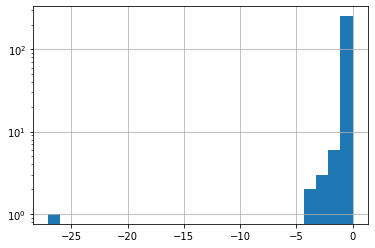

In [57]:
dfm_verify["diff"].hist(bins=25, log=True)

Most are small, negligible differences. one stands out. Let's see.

In [58]:
dfm_verify[dfm_verify["diff"] < -25]

,,cumulative,daily_new,diff
Province/State,Country/Region,,,
,West Bank and Gaza,484,353.0,-27.066116


What happened here?

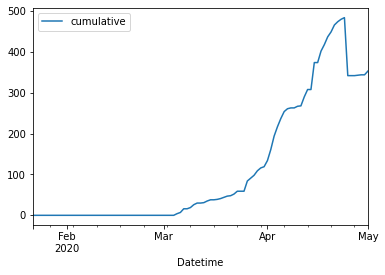

In [60]:
dfm[dfm["Country/Region"] == "West Bank and Gaza"].plot(x="Datetime", y="cumulative")

Hmm, ok, data quality issue or they corrected the numbers. Ignoring this for now. Moving on...

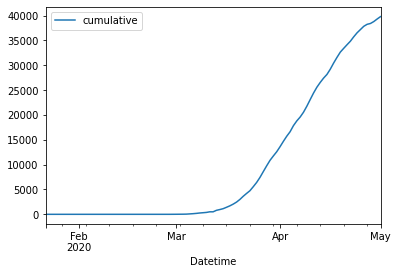

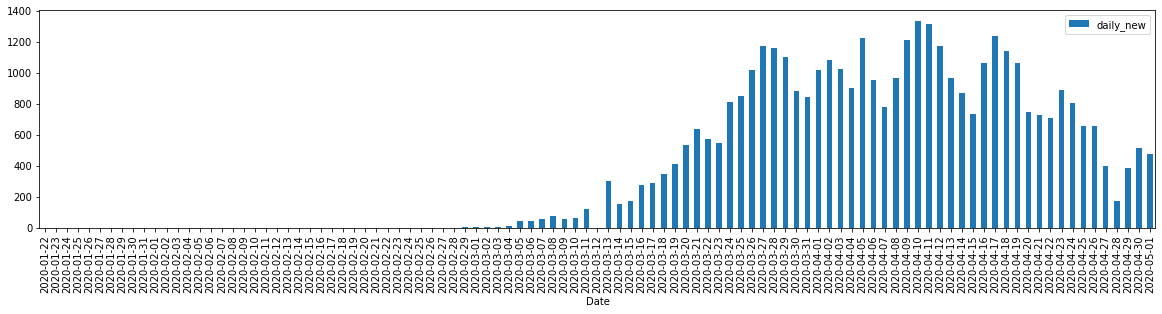

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

data_nl = dfm[(dfm["Country/Region"] == "Netherlands") & (dfm["Province/State"] == "")]
data_nl.plot(x="Datetime", y="cumulative")
data_nl.plot(x="Date", y="daily_new", kind="bar", figsize=(20, 4))

# plt.yscale("log")
# plt.xscale("log")

This looks legit.

In [76]:
jh_map = KeplerGl(
    height=800, 
    data={"data": dfm},
)
jh_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'data':       Province/State Country/Region   Lat  Long        Date  cumulative  \
0           …

# This doesn't work!
Too bad.

- Circles won't disappear if there are 0 new cases. They remain quite large. Even if the radius starts at 0. That makes no sense.
- I wanted to be able to select a larger time range in order to actually use the timeRange as a slider (i.e. make it clickable for drag & drop). Sadly, there is no way to tell Kepler to sum over the data in the timeRange. It just draws circles on top of each other. This could be quite nice with a low opacity/alpha if we have invidual coordinates per case, but since they're all in the centroid of the country, it's no good. I could put some random jitter on each point, but that has the potential of showing many Covid-19 cases in areas that are not really affected. (and the jitter should be large for large countries, small for small countries, definitely within the country borders, not in the sea, etc...)

This proves the point of my blog post: Kepler.gl is suitable for unaggregated data (individual cases/uber rides/whatever), but not *really* for aggregated data.